# <div style="text-align: center">Email classifier by theme </div>


### <div style="text-align: right"> by Mohamed Bouzid </div>




# Contents :

[I. Dataset](#1)

[II. Exploratory Data Analysis](#2)

[III. Pre-processing](#3)

[IV. Modeling](#4)

<a id="1"> </a>
# I. Dataset

### Load libraries used in this project

In [509]:
# data manipulation and information
import numpy as np
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# transformation, encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
import re
from nltk.corpus import stopwords
stop = stopwords.words('english')

# estimators
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

# data sampling
from sklearn.model_selection import train_test_split, GridSearchCV

# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

### Load the dataset

In [472]:
df = pd.read_csv('giskard_dataset.csv', sep=';', index_col=[0]) # extract dataset
df = df.reset_index().drop(axis=1, columns = 'index') # this avoid index corruption after removing

df.head()

,Target,Message
0,internal company policy,Message-ID: <32715630.1075840547840.JavaMail.e...
1,alliances / partnerships,Message-ID: <8721012.1075863428380.JavaMail.ev...
2,internal company operations,Message-ID: <8687721.1075852656109.JavaMail.ev...
3,internal company operations,Message-ID: <16562450.1075846168630.JavaMail.e...
4,internal projects -- progress and strategy,Message-ID: <955111.1075858690252.JavaMail.eva...


In [473]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Target   879 non-null    object
 1   Message  879 non-null    object
dtypes: object(2)
memory usage: 13.9+ KB


<a id="2"> </a>
# II. Exploratory Data Analysis

Exploratory Data Analysis (EDA) is an analysis approach that identifies general patterns in the data. 

In [474]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Target   879 non-null    object
 1   Message  879 non-null    object
dtypes: object(2)
memory usage: 13.9+ KB


Here, the data is mainly string values, meaning no numeric patterns, however we still can still look at the ratio of each target class. 

In [475]:
df['Target'].value_counts()

regulations and regulators (includes price caps)    184
california energy crisis / california politics      149
internal projects -- progress and strategy          109
internal company operations                          78
political influence / contributions / contacts       76
internal company policy                              67
 company image -- current                            59
legal advice                                         47
alliances / partnerships                             43
company image -- changing / influencing              37
talking points                                       13
meeting minutes                                      13
trip reports                                          4
Name: Target, dtype: int64

Text(0.5, 1.0, 'Target composition')

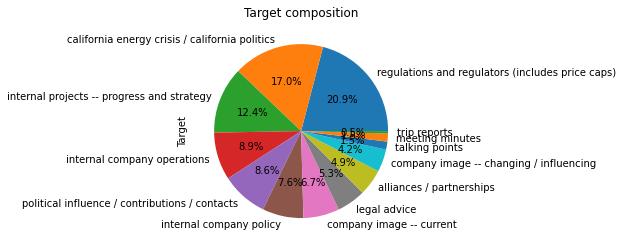

In [476]:
# composition of the target
df['Target'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Target composition')

We can see that half of the messages are related to : 
- regulations and regulators (20.9%)
- california energy crisis / california politics (17%)
- internal projects -- progress and strategy (12.4%)

<a id="3"> </a>
# III. Pre-processing

### Cleaning check

In [477]:
# check duplicates to clean
df.duplicated().value_counts()

False    879
dtype: int64

The dataset has no duplicates

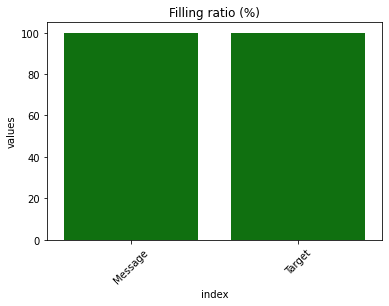

In [478]:
# calculation of the filling ratio per column
ratio = pd.DataFrame(
    data=(100 - 100*(df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)),
    columns=['values']).reset_index()

# color criteria (red = not full / green = full)
colors = ['red' if y<100 else 'green' for y in ratio['values']]

# chart
sns.barplot(x='index', y='values', data=ratio, palette=colors)

plt.title('Filling ratio (%)')
plt.tick_params(axis='x', rotation=45)

The dataset has no missing values

### Feature Engineering

In [479]:
# check the content of a Message
print(df.loc[9]['Message'])

Message-ID: <1637509.1075843546651.JavaMail.evans@thyme>
Date: Thu, 31 May 2001 04:19:00 -0700 (PDT)
From: susan.mara@enron.com
To: arem@electric.com, tracy.fairchild@edelman.com, erica.manuel@edelman.com,
	nplotkin@tfglobby.com
Subject: Ackerman to talk to Wolak
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Susan J Mara
X-To: arem@electric.com, tracy.fairchild@edelman.com, erica.manuel@edelman.com, nplotkin@tfglobby.com
X-cc: 
X-bcc: 
X-Folder: \Jeff_Dasovich_June2001\Notes Folders\All documents
X-Origin: DASOVICH-J
X-FileName: jdasovic.nsf

Gary has been seeing Frank Wolak all over the place on the media scene.  I 
asked him to ask Frank to do something POSITIVE and under the state's own 
control and push DA.  Gary is also speaking to a bunch of CEOs (with Anjali 
of the ISO and Carl Wood) and he said he would carry our message to them as 
well.

Sue Mara
Enron Corp.
Tel: (415) 782-7802
Fax:(415) 782-7854


We can see that the above message respects MIME 1 format. Headers such as `Date`, and `Subject`, the body content of the email and `From` can be used as the features. 

Fortunately, python has a package named `email` which can manage MIME format, therefore we can use it for our dataset ! 

In [480]:
import email

# Nested function in 'get_features' used for preparing features contents 
def insert_value(dictionary, key, value):
    if key in dictionary:
        values = dictionary.get(key)
        values.append(value)
        dictionary[key] = values
    else:
        dictionary[key] = [value]
    return dictionary


# Function used for extracting features into our dataframe 
def get_headers(df, header_names):
    headers = {}
    messages = df['Message']
    for message in messages:
        e = email.message_from_string(message)
        for item in header_names:
            header = e.get(item)
            insert_value(dictionary = headers, key = item, value = header) 
    return headers
header_names = ['date', 'subject', 'from']    
headers = get_headers(df, header_names)

In [481]:
# Function used for extracting body text from emails
def get_messages(df):
    messages = []
    for item in df['Message']:
        # Return a message object structure from a string
        e = email.message_from_string(item)    
        # get message body  
        message_body = e.get_payload()
        messages.append(message_body)
    return messages
msg_body = get_messages(df)
df['body'] = msg_body

df.head()

,Target,Message,body
0,internal company policy,Message-ID: <32715630.1075840547840.JavaMail.e...,"To:GILBERT-SMITH, DOUGLAS\nEmail:doug.gilbert-..."
1,alliances / partnerships,Message-ID: <8721012.1075863428380.JavaMail.ev...,\n\n -----Original Message-----\nFrom: \tKoepk...
2,internal company operations,Message-ID: <8687721.1075852656109.JavaMail.ev...,"John Brindle, David Cromley and others in the ..."
3,internal company operations,Message-ID: <16562450.1075846168630.JavaMail.e...,Yes. Contact either Gia or John and get the b...
4,internal projects -- progress and strategy,Message-ID: <955111.1075858690252.JavaMail.eva...,\nThis is something interesting to put in your...


In [482]:
# Function to add headers and values to the main dataframe
def add_headers(df, header_list):
    for label in header_list:
        df_new = pd.DataFrame(headers[label], columns = [label]) # make dataframe based on header_list
        if label not in df.columns: # avoid duplicates
            df = pd.concat([df, df_new], axis = 1)
    return df

header_list = ['date', 'subject', 'from']
df = add_headers(df, header_list)


df.head()

,Target,Message,body,date,subject,from
0,internal company policy,Message-ID: <32715630.1075840547840.JavaMail.e...,"To:GILBERT-SMITH, DOUGLAS\nEmail:doug.gilbert-...","Wed, 11 Jul 2001 08:29:27 -0700 (PDT)",Confidential Information and Securities Trading,legalonline-compliance@enron.com
1,alliances / partnerships,Message-ID: <8721012.1075863428380.JavaMail.ev...,\n\n -----Original Message-----\nFrom: \tKoepk...,"Tue, 26 Jun 2001 09:40:17 -0700 (PDT)","FW: Venezuela FX and inflation forecasts, June...",j.kaminski@enron.com
2,internal company operations,Message-ID: <8687721.1075852656109.JavaMail.ev...,"John Brindle, David Cromley and others in the ...","Wed, 13 Jun 2001 06:05:07 -0700 (PDT)",Enron Expatriates in India,steven.kean@enron.com
3,internal company operations,Message-ID: <16562450.1075846168630.JavaMail.e...,Yes. Contact either Gia or John and get the b...,"Mon, 21 Aug 2000 00:30:00 -0700 (PDT)",Re: PLEASE READ & RESPOND,steven.kean@enron.com
4,internal projects -- progress and strategy,Message-ID: <955111.1075858690252.JavaMail.eva...,\nThis is something interesting to put in your...,"Sat, 16 Jun 2001 17:36:06 -0700 (PDT)",FW: ISO's Response to BPA Rebuttal of Sheffrin...,b..sanders@enron.com


Now we want to manipulate the date column. To do this, we convert it to datetime format, then we would like to keep only the months (alphabetical) and years (numerical)

In [483]:
df['date'] = pd.to_datetime(df['date'], utc=True) # utc conversion argument needed otherwise reading error is raised

# Splitting of the Date column
df['year'] = df['date'].dt.year
df['month'] = pd.to_datetime(df['date'], format='%m').dt.month_name()

df.head()

,Target,Message,body,date,subject,from,year,month
0,internal company policy,Message-ID: <32715630.1075840547840.JavaMail.e...,"To:GILBERT-SMITH, DOUGLAS\nEmail:doug.gilbert-...",2001-07-11 15:29:27+00:00,Confidential Information and Securities Trading,legalonline-compliance@enron.com,2001,July
1,alliances / partnerships,Message-ID: <8721012.1075863428380.JavaMail.ev...,\n\n -----Original Message-----\nFrom: \tKoepk...,2001-06-26 16:40:17+00:00,"FW: Venezuela FX and inflation forecasts, June...",j.kaminski@enron.com,2001,June
2,internal company operations,Message-ID: <8687721.1075852656109.JavaMail.ev...,"John Brindle, David Cromley and others in the ...",2001-06-13 13:05:07+00:00,Enron Expatriates in India,steven.kean@enron.com,2001,June
3,internal company operations,Message-ID: <16562450.1075846168630.JavaMail.e...,Yes. Contact either Gia or John and get the b...,2000-08-21 07:30:00+00:00,Re: PLEASE READ & RESPOND,steven.kean@enron.com,2000,August
4,internal projects -- progress and strategy,Message-ID: <955111.1075858690252.JavaMail.eva...,\nThis is something interesting to put in your...,2001-06-17 00:36:06+00:00,FW: ISO's Response to BPA Rebuttal of Sheffrin...,b..sanders@enron.com,2001,June


In [484]:
# merge date, subject and body columns into a new text column
df['text'] = df['month'] + ' ' + df['year'].astype('str') + ' ' + df['subject'] + ' ' + df['body']

# drop the columns 'subject' and 'body'
df.drop(['Message', 'date', 'month', 'year', 'subject', 'body'], axis=1, inplace=True)

df.head()

,Target,from,text
0,internal company policy,legalonline-compliance@enron.com,July 2001 Confidential Information and Securit...
1,alliances / partnerships,j.kaminski@enron.com,June 2001 FW: Venezuela FX and inflation forec...
2,internal company operations,steven.kean@enron.com,June 2001 Enron Expatriates in India John Brin...
3,internal company operations,steven.kean@enron.com,August 2000 Re: PLEASE READ & RESPOND Yes. Co...
4,internal projects -- progress and strategy,b..sanders@enron.com,June 2001 FW: ISO's Response to BPA Rebuttal o...


In [485]:
df['text'] = df['text'].replace({'FW: ': '', 'RE: ': '', 'Fw: ': '', 'Re: ': ''}, regex=True)

In [486]:
df.head()

,Target,from,text
0,internal company policy,legalonline-compliance@enron.com,July 2001 Confidential Information and Securit...
1,alliances / partnerships,j.kaminski@enron.com,June 2001 Venezuela FX and inflation forecasts...
2,internal company operations,steven.kean@enron.com,June 2001 Enron Expatriates in India John Brin...
3,internal company operations,steven.kean@enron.com,August 2000 PLEASE READ & RESPOND Yes. Contac...
4,internal projects -- progress and strategy,b..sanders@enron.com,June 2001 ISO's Response to BPA Rebuttal of Sh...


Now, do the following to preprocess text:
- lowercasing all words
- Remove extra new lines
- Remove extra tabs, punctuations, commas
- Remove extra white spaces
- Remove stopwords

In [487]:
# Libraries
import nltk
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')



nltk_ponct = nltk.RegexpTokenizer(r'\w{2,}') # tokenize (split words):
                                                        # {2,} : 2+ words
        
from nltk.corpus import stopwords # remove unuseful words (to, the, etc.)
stopword = stopwords.words('english')

from nltk.stem import WordNetLemmatizer # reduce words to singular nouns
wordnet_lemmatizer = WordNetLemmatizer()

from nltk.stem import SnowballStemmer # find the root of the word
snowball_stemmer = SnowballStemmer('english')

# Function
def nlp(text):
    '''Processes the text to extract the keywords needed for data analysis'''
    # keep original messages only (truncate '-----Original Message-----')
    keyword = '-----'
    if keyword in text:
        text=text[:text.index(keyword) + len(keyword)]    
    # switch to lower case letters
    text = text.lower()
    # split words and removes bridging
    text = nltk_ponct.tokenize(text)
    # remove unnecessary words
    text = [word for word in text if word not in stopword]
    # reduce words to singular nouns
    text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    # find the root of the word
    text = [snowball_stemmer.stem(word) for word in text]

    #return text : if we want the tokenized format (list)
    return ' '.join(text) # to get the str format

[nltk_data] Downloading package omw-1.4 to /home/tv/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /home/tv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/tv/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [488]:
# apply the above cleaning function to our text column
df['clean_text'] = df['text'].map(nlp)

df.head()

,Target,from,text,clean_text
0,internal company policy,legalonline-compliance@enron.com,July 2001 Confidential Information and Securit...,juli 2001 confidenti inform secur trade gilber...
1,alliances / partnerships,j.kaminski@enron.com,June 2001 Venezuela FX and inflation forecasts...,june 2001 venezuela fx inflat forecast june 2001
2,internal company operations,steven.kean@enron.com,June 2001 Enron Expatriates in India John Brin...,june 2001 enron expatri india john brindl davi...
3,internal company operations,steven.kean@enron.com,August 2000 PLEASE READ & RESPOND Yes. Contac...,august 2000 pleas read respond yes contact eit...
4,internal projects -- progress and strategy,b..sanders@enron.com,June 2001 ISO's Response to BPA Rebuttal of Sh...,june 2001 iso respons bpa rebutt sheffrin stud...


In [489]:
# merge from & clean_text columns and drop from & text columns
df['features'] = df['from'] + ' ' + df['clean_text']

# drop the columns 'subject' and 'body'
df.drop(['from', 'text', 'clean_text'], axis=1, inplace=True)

df.head()

,Target,features
0,internal company policy,legalonline-compliance@enron.com juli 2001 con...
1,alliances / partnerships,j.kaminski@enron.com june 2001 venezuela fx in...
2,internal company operations,steven.kean@enron.com june 2001 enron expatri ...
3,internal company operations,steven.kean@enron.com august 2000 pleas read r...
4,internal projects -- progress and strategy,b..sanders@enron.com june 2001 iso respons bpa...


Finally, we want to encode the `Target` column containing the class labels

In [490]:
def label_encoder(data):
    class_le = LabelEncoder()
    # apply label encoder on the 'Target' column
    y = class_le.fit_transform(data['Target'])
    return y

In [491]:
y = label_encoder(df)

<a id="4"> </a>
# IV. Modeling

We want to compare several machine learning models in order to choose one, then tune its hyperparameters to optimize it. 

In [492]:
features = df['features']

X = features
y = y

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Using Bag-of-Words

In [493]:
start = time.time()
vectorizer = CountVectorizer(min_df=5, max_features=5000)
X_train_bow = vectorizer.fit_transform(X_train)
end = time.time()
print("Execution time (sec): ",(end - start))

Execution time (sec):  0.10384917259216309


In [494]:
start = time.time()
X_train_bow = X_train_bow.toarray()
print("X_train_bow.shape: ",X_train_bow.shape)
end = time.time()
print("Execution time (sec): ",(end - start))

X_train_bow.shape:  (703, 2766)
Execution time (sec):  0.0030410289764404297


In [495]:
# create dataframe to store results
f1_data = {
    'Algorithm': ['Gaussian NB', 'Multinomial NB','Decision Tree','SVC','AdaBoost','ANN', 'KNN', 'LGB'],
    'BoW': ''
}
f1_df = pd.DataFrame(f1_data)


acc_data = {
    'Algorithm': ['Gaussian NB', 'Multinomial NB','Decision Tree','SVC','AdaBoost','ANN', 'KNN', 'LGB'],
    'BoW': ''
}
acc_df = pd.DataFrame(acc_data)

In [496]:
models = [GaussianNB(), MultinomialNB(), DecisionTreeClassifier(), LinearSVC(), 
          AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=5),
         MLPClassifier(hidden_layer_sizes=(10,)), KNeighborsClassifier(), LGBMClassifier()]

names = ["Gaussian NB", "Multinomial NB", "Decision Tree", "SVC", "AdaBoost", "ANN", 'KNN', 'LGB']

acc_scores = []
f1_scores = []
exec_times = []

for model, name in zip(models, names):
    print(name)
    start = time.time()
    scoring = {
        'acc': 'accuracy',
        'f1_mac': 'f1_macro',
    }
    scores = cross_validate(model, X_train_bow, y_train, cv=10, n_jobs=4, scoring=scoring)
    training_time = (time.time() - start)
    print("accuracy: ", scores['test_acc'].mean())
    print("f1_score: ", scores['test_f1_mac'].mean())
    print("time (sec): ", training_time)
    print("\n")
    
    acc_scores.append(scores['test_acc'].mean())
    f1_scores.append(scores['test_f1_mac'].mean())
    exec_times.append(training_time)
    
acc_df['BoW'] = acc_scores
f1_df['BoW'] = f1_scores
acc_df['time'] = exec_times
acc_df

Gaussian NB
accuracy:  0.2360764587525151
f1_score:  0.15972275222521132
time (sec):  0.3027048110961914


Multinomial NB
accuracy:  0.32018108651911464
f1_score:  0.22435927112882878
time (sec):  0.39748072624206543


Decision Tree
accuracy:  0.3030784708249497
f1_score:  0.23243612495731708
time (sec):  0.5391268730163574


SVM
accuracy:  0.29591549295774644
f1_score:  0.21425444544188324
time (sec):  1.185464859008789


AdaBoost
accuracy:  0.3142857142857143
f1_score:  0.21719641202709156
time (sec):  1.8265445232391357


ANN
accuracy:  0.3556338028169014
f1_score:  0.23481329185539238
time (sec):  10.358669519424438


KNN
accuracy:  0.2560160965794769
f1_score:  0.17119369767710232
time (sec):  0.23739862442016602


LGB
accuracy:  0.3556338028169014
f1_score:  0.25421241978555703
time (sec):  4.796592473983765




,Algorithm,BoW,time
0,Gaussian NB,0.236076,0.302705
1,Multinomial NB,0.320181,0.397481
2,Decision Tree,0.303078,0.539127
3,SVM,0.295915,1.185465
4,AdaBoost,0.314286,1.826545
5,ANN,0.355634,10.358670
6,KNN,0.256016,0.237399
7,LGB,0.355634,4.796592


### Using TF-IDF

In [497]:
start = time.time()
vectorizer = TfidfVectorizer(min_df=5, max_features=5000)
X_train_tf = vectorizer.fit_transform(X_train)

X_train_tf = X_train_tf.toarray()
print('X_train_tf.shape: ', X_train_tf.shape)

end = time.time()
print("Execution time (sec): ", (end - start))

X_train_tf.shape:  (703, 2766)
Execution time (sec):  0.10550212860107422


In [498]:
models = [GaussianNB(), MultinomialNB(), DecisionTreeClassifier(), LinearSVC(), 
          AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=5),
         MLPClassifier(hidden_layer_sizes=(10,)), KNeighborsClassifier(), LGBMClassifier()]

names = ["Gaussian NB", "Multinomial NB", "Decision Tree", "SVC", "AdaBoost", "ANN", 'KNN', 'LGB']

acc_scores = []
f1_scores = []
exec_times = []

for model, name in zip(models, names):
    print(name)
    start = time.time()
    scoring = {
        'acc': 'accuracy',
        'f1_mac': 'f1_macro',
    }
    scores = cross_validate(model, X_train_tf, y_train, cv=10, n_jobs=4, scoring=scoring)
    training_time = (time.time() - start)
    print("accuracy: ", scores['test_acc'].mean())
    print("f1_score: ", scores['test_f1_mac'].mean())
    print("time (sec): ", training_time)
    print("\n")
    
    acc_scores.append(scores['test_acc'].mean())
    f1_scores.append(scores['test_f1_mac'].mean())
    exec_times.append(training_time)
    
acc_df['TfIdf'] = acc_scores
f1_df['TfIdf'] = f1_scores
acc_df['TfIdf_time'] = exec_times
acc_df

Gaussian NB
accuracy:  0.24307847082494968
f1_score:  0.1643207218429053
time (sec):  0.29660844802856445


Multinomial NB
accuracy:  0.2759356136820925
f1_score:  0.11197179298460443
time (sec):  0.16919898986816406


Decision Tree
accuracy:  0.30012072434607645
f1_score:  0.20510360536519717
time (sec):  0.6952595710754395


SVM
accuracy:  0.3498189134808853
f1_score:  0.2428286079599548
time (sec):  0.3494570255279541


AdaBoost
accuracy:  0.27450704225352107
f1_score:  0.18348233798021532
time (sec):  2.2353360652923584


ANN
accuracy:  0.35418511066398395
f1_score:  0.23069861536421704
time (sec):  10.33318543434143


KNN
accuracy:  0.31138832997987925
f1_score:  0.2089755370568512
time (sec):  0.22267389297485352


LGB
accuracy:  0.36710261569416497
f1_score:  0.25095283861466905
time (sec):  9.36580204963684




,Algorithm,BoW,time,TfIdf,TfIdf_time
0,Gaussian NB,0.236076,0.302705,0.243078,0.296608
1,Multinomial NB,0.320181,0.397481,0.275936,0.169199
2,Decision Tree,0.303078,0.539127,0.300121,0.695260
3,SVM,0.295915,1.185465,0.349819,0.349457
4,AdaBoost,0.314286,1.826545,0.274507,2.235336
5,ANN,0.355634,10.358670,0.354185,10.333185
6,KNN,0.256016,0.237399,0.311388,0.222674
7,LGB,0.355634,4.796592,0.367103,9.365802


We conclude that `LinearSVC` with TF-IDF has the best performance-duration ratio. 

The score is low, maybe due to the low volume of data (only 879 rows for 13 classes). 

We decide to optimize the model by tuning the hyperparameters using GridSearchCV. 

### Model tuning

In [499]:
# optimizing the "best" estimator

#param_grid = {'kernel':('linear', 'rbf'), 'C':[1, 10]}


param_grid = [{'C': [1, 10, 100, 1000],
               'class_weight': ['balanced', 'None'],  
               'fit_intercept': ['True', 'False'], 
               'intercept_scaling': [1, 5, 10], 
               'tol': [0.1, 0.2, 0.4, 0.8, 1]
              }]

grid = GridSearchCV(LinearSVC(), param_grid, cv=5, n_jobs=8)

In [505]:
# prepare the data 

vectorizer = TfidfVectorizer(min_df=5, max_features=5000)
X_train_f = vectorizer.fit_transform(X_train)
X_test_f = vectorizer.transform(X_test)


X_train_f = X_train_f.toarray()
X_test_f = X_test_f.toarray()

# ______


print('X_train_f.shape: ', X_train_f.shape)
print('X_test_f.shape: ', X_test_f.shape)
print('y_test.shape: ', X_test_f.shape)

X_train_f.shape:  (703, 2766)
X_test_f.shape:  (176, 2766)
y_test.shape:  (176, 2766)


In [501]:
# training
grid.fit(X_train_f, y_train)

GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=8,
             param_grid=[{'C': [1, 10, 100, 1000],
                          'class_weight': ['balanced', 'None'],
                          'fit_intercept': ['True', 'False'],
                          'intercept_scaling': [1, 5, 10],
                          'tol': [0.1, 0.2, 0.4, 0.8, 1]}])

In [502]:
# Best score
grid.best_score_

0.3612867274569402

In [503]:
# Best estimator/hyperparameters
model = grid.best_estimator_
model

LinearSVC(C=1, class_weight='balanced', fit_intercept='True',
          intercept_scaling=5, tol=0.8)

In [506]:
model.score(X_test_f, y_test)

0.4034090909090909

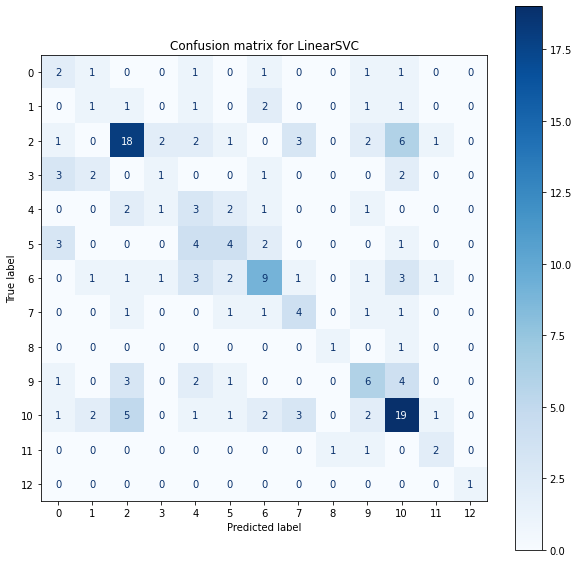

In [527]:
# Confusion matrix of correct/incorrect estimates

fig, ax = plt.subplots(figsize=(10, 10))

matrix_lr = plot_confusion_matrix(grid, X_test_f, y_test,
                                 cmap=plt.cm.Blues, ax=ax)

plt.title('Confusion matrix for LinearSVC')
plt.show(matrix_lr)
plt.show()